# 1 Setlect POI Data using Ward level KDE Correlation Matrix

## 1.1 Define Fucntions

In [1]:
"""
POI-Population Correlation Analysis with Residential Mask for Jaipur City
========================================================================

This script analyzes the correlation between POI kernel density and population
at ward level using different bandwidths, constrained to residential areas only.

Analysis Flow:
1. Load POI data, ward boundaries, city boundary, and GHSL residential raster
2. For each POI category and bandwidth:
   - Perform kernel density estimation (KDE)
   - Clip KDE to city boundary
   - Apply residential mask (keep values where GHSL > 0)
   - Aggregate to ward boundaries using zonal statistics
   - Calculate correlation with population
3. Generate correlation matrix and visualizations

Key Features:
- Uses GHSL residential building footprint as analysis mask
- Bandwidths: 400m, 800m, 1200m, 1600m, 2000m, 2400m, 2800m, 3200m
- Only analyzes KDE values within residential areas (GHSL > 0)
- Aggregates results by ward boundaries within residential areas
"""

'\nPOI-Population Correlation Analysis with Residential Mask for Jaipur City\n========================================================================\n\nThis script analyzes the correlation between POI kernel density and population\nat ward level using different bandwidths, constrained to residential areas only.\n\nAnalysis Flow:\n1. Load POI data, ward boundaries, city boundary, and GHSL residential raster\n2. For each POI category and bandwidth:\n   - Perform kernel density estimation (KDE)\n   - Clip KDE to city boundary\n   - Apply residential mask (keep values where GHSL > 0)\n   - Aggregate to ward boundaries using zonal statistics\n   - Calculate correlation with population\n3. Generate correlation matrix and visualizations\n\nKey Features:\n- Uses GHSL residential building footprint as analysis mask\n- Bandwidths: 400m, 800m, 1200m, 1600m, 2000m, 2400m, 2800m, 3200m\n- Only analyzes KDE values within residential areas (GHSL > 0)\n- Aggregates results by ward boundaries within 

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.neighbors import KernelDensity
from scipy.stats import pearsonr
import rasterio
from rasterio.transform import from_bounds
from rasterio.features import rasterize
from rasterio.mask import mask
from rasterio.warp import reproject, Resampling
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
import warnings
import os
warnings.filterwarnings('ignore')

In [3]:
import os
os.getcwd()
os.chdir("G:/OneDrive/casa0010dissertation/00_06 jaipur code_mgwr")

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import geopandas as gpd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from time import time
import sys

In [5]:
# Basic plotting settings for matplotlib and seaborn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl

import contextily as cx
from matplotlib.colors import Normalize

# Pandas display settings
pd.set_option('display.max_columns', None)

# Matplotlib basic settings
plt.style.use('default')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['font.size'] = 16
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

# Grid settings
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.axis'] = 'both'
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['grid.color'] = 'gray'
plt.rcParams['grid.linestyle'] = '-'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['axes.axisbelow'] = True

# Spine/border settings
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['axes.edgecolor'] = 'gray'

# Matplotlib figure DPI setting
mpl.rcParams['figure.dpi'] = 300


sns.set_style("whitegrid", {
    "axes.spines.left": True,
    "axes.spines.bottom": True,
    "axes.spines.top": True,
    "axes.spines.right": True,
    "axes.linewidth": 0.5,
    "axes.edgecolor": "gray",
    "grid.color": "gray",
    "grid.alpha": 0.3,
    "axes.facecolor": "white"
})

sns.set_context(context="paper", font_scale=1.5, rc=None)
sns.set(font="serif")

# Additional libraries for geo-spatial analysis (if needed)
import geopandas as gpd
import contextily as cx
from matplotlib.colors import Normalize

In [6]:
# Try to import rasterstats for efficient raster-polygon aggregation
try:
    from rasterstats import zonal_stats
    RASTERSTATS_AVAILABLE = True
except ImportError:
    RASTERSTATS_AVAILABLE = False
    print("Warning: rasterstats not available. Using slower aggregation method.")
    print("Install with: pip install rasterstats")

class POIPopulationAnalysisWithMask:
    def __init__(self, wards_gdf, pois_gdf, city_boundary_gdf, residential_raster_path, population_column='POP', poi_classification_column='poi_category'):
        """
        Initialize the POI-Population correlation analysis with residential mask.

        Parameters:
        -----------
        wards_gdf : GeoDataFrame
            Ward boundaries with population data for each ward
        pois_gdf : GeoDataFrame
            POI points with category information (must have poi_classification_column)
        city_boundary_gdf : GeoDataFrame
            Polygon boundary representing the extent of Jaipur city
        residential_raster_path : str
            Path to residential building footprint raster (GeoTIFF)
        population_column : str
            Name of the population column in wards_gdf
        poi_classification_column : str
            Name of the column used for POI classification (default: 'poi_category')
        """
        # Copy input data to avoid modifying originals
        self.wards_gdf = wards_gdf.copy()
        self.pois_gdf = pois_gdf.copy()
        self.city_boundary_gdf = city_boundary_gdf.copy()
        self.population_column = population_column
        self.poi_classification_column = poi_classification_column
        self.residential_raster_path = residential_raster_path

        print("=== INITIALIZING POI-POPULATION ANALYSIS WITH RESIDENTIAL MASK ===")

        # Load and process residential raster
        self._load_residential_mask()

        # Ensure all datasets use the same coordinate reference system
        target_crs = self.wards_gdf.crs
        if self.pois_gdf.crs != target_crs:
            self.pois_gdf = self.pois_gdf.to_crs(target_crs)
        if self.city_boundary_gdf.crs != target_crs:
            self.city_boundary_gdf = self.city_boundary_gdf.to_crs(target_crs)

        # If using geographic coordinates, convert to projected for accurate distance calculations
        if self.wards_gdf.crs.is_geographic:
            # Use UTM zone 43N for Jaipur, India
            projected_crs = 'EPSG:32643'  # UTM Zone 43N
            self.wards_gdf = self.wards_gdf.to_crs(projected_crs)
            self.pois_gdf = self.pois_gdf.to_crs(projected_crs)
            self.city_boundary_gdf = self.city_boundary_gdf.to_crs(projected_crs)
            print(f"Converted coordinates to {projected_crs} for accurate distance calculations")

            # Reproject residential raster if needed
            self._reproject_residential_mask(projected_crs)

        # Get the city boundary as a single polygon (union if multiple polygons)
        self.city_polygon = self.city_boundary_gdf.unary_union

        # Validate required columns
        self._validate_data_columns()

        # Display basic information about the datasets
        self._display_data_summary()

    def _load_residential_mask(self):
        """Load the residential building footprint raster."""
        print(f"Loading residential mask from: {self.residential_raster_path}")

        if not os.path.exists(self.residential_raster_path):
            raise FileNotFoundError(f"Residential raster file not found: {self.residential_raster_path}")

        # Load residential raster
        with rasterio.open(self.residential_raster_path) as src:
            self.residential_data = src.read(1)
            self.residential_transform = src.transform
            self.residential_crs = src.crs
            self.residential_bounds = src.bounds
            self.residential_shape = (src.height, src.width)

        print(f"Residential raster loaded: {self.residential_shape[1]}x{self.residential_shape[0]} pixels")
        print(f"Residential data CRS: {self.residential_crs}")
        print(f"Residential pixel count: {np.sum(self.residential_data > 0)} residential pixels")

    def _reproject_residential_mask(self, target_crs):
        """Reproject residential mask to target CRS if needed."""
        if self.residential_crs != target_crs:
            print(f"Reprojecting residential mask from {self.residential_crs} to {target_crs}")

            # This is a placeholder - in practice, you might need to reproject
            # the raster file externally using gdalwarp or rasterio.warp
            print("Note: If CRS mismatch causes issues, preprocess the residential raster to match ward CRS")

    def _validate_data_columns(self):
        """Validate that all required columns exist."""
        if self.population_column not in self.wards_gdf.columns:
            raise ValueError(f"Population column '{self.population_column}' not found in ward data. Available columns: {list(self.wards_gdf.columns)}")

        if 'Id' not in self.wards_gdf.columns:
            raise ValueError(f"Ward ID column 'Id' not found in ward data. Available columns: {list(self.wards_gdf.columns)}")

        if self.poi_classification_column not in self.pois_gdf.columns:
            raise ValueError(f"POI classification column '{self.poi_classification_column}' not found in POI data. Available columns: {list(self.pois_gdf.columns)}")

    def _display_data_summary(self):
        """Display summary information about loaded datasets."""
        print(f"\n=== DATA SUMMARY ===")
        print(f"Wards: {len(self.wards_gdf)} polygons")
        print(f"Ward ID range: {self.wards_gdf['Id'].min()} to {self.wards_gdf['Id'].max()}")
        print(f"Population range: {self.wards_gdf[self.population_column].min()} to {self.wards_gdf[self.population_column].max()}")
        print(f"POIs: {len(self.pois_gdf)} points across {len(self.pois_gdf[self.poi_classification_column].unique())} categories")
        print(f"POI categories: {sorted(self.pois_gdf[self.poi_classification_column].unique())}")
        print(f"City boundary area: {self.city_polygon.area / 1e6:.2f} km²")
        print(f"Residential area: {np.sum(self.residential_data > 0) * 0.01:.2f} km² (100m pixels)")

    def create_analysis_grid(self, pixel_size=100):
        """
        Create a raster grid for analysis covering the city boundary area.

        Parameters:
        -----------
        pixel_size : float
            Size of each raster cell/pixel in meters

        Returns:
        --------
        tuple : (transform, shape, bounds)
            Raster transform, shape, and bounds for the grid
        """
        # Get bounds of the city boundary with buffer for edge effects
        buffer_distance = 1000  # 1km buffer to avoid edge effects in KDE
        buffered_boundary = self.city_polygon.buffer(buffer_distance)
        minx, miny, maxx, maxy = buffered_boundary.bounds

        # Calculate raster dimensions based on pixel size
        width = int(np.ceil((maxx - minx) / pixel_size))
        height = int(np.ceil((maxy - miny) / pixel_size))

        # Create the raster transform (maps pixel coordinates to geographic coordinates)
        transform = from_bounds(minx, miny, maxx, maxy, width, height)

        # Store grid parameters for later use
        self.analysis_bounds = (minx, miny, maxx, maxy)
        self.analysis_shape = (height, width)
        self.analysis_transform = transform
        self.pixel_size = pixel_size

        print(f"Created analysis grid: {width}x{height} pixels ({pixel_size}m resolution)")
        print(f"Grid covers {(maxx-minx)/1000:.1f}km x {(maxy-miny)/1000:.1f}km area")

        return transform, (height, width), (minx, miny, maxx, maxy)

    def create_residential_mask_for_analysis(self):
        """
        Create a residential mask aligned with the analysis grid.
        Areas with values in GHSL (>0) are set to True, indicating residential areas.

        Returns:
        --------
        numpy.ndarray : Boolean mask where True = residential area (GHSL has value > 0)
        """
        print("Creating residential mask for analysis grid...")

        # Create coordinate arrays for analysis grid
        height, width = self.analysis_shape
        x_coords = np.arange(width) * self.pixel_size + self.analysis_bounds[0] + self.pixel_size/2
        y_coords = np.arange(height) * self.pixel_size + self.analysis_bounds[1] + self.pixel_size/2

        # Create residential mask by checking overlap with residential raster
        residential_mask = np.zeros(self.analysis_shape, dtype=bool)

        # Sample residential raster at analysis grid points
        for i in range(height):
            for j in range(width):
                x, y = x_coords[j], y_coords[height-1-i]  # Note: raster y is flipped

                # Convert to residential raster coordinates
                col = int((x - self.residential_bounds[0]) / abs(self.residential_transform[0]))
                row = int((self.residential_bounds[3] - y) / abs(self.residential_transform[4]))

                # Check if within residential raster bounds and has residential value
                if (0 <= row < self.residential_shape[0] and
                    0 <= col < self.residential_shape[1]):
                    # Set to True where GHSL has values (>0), preserving KDE results
                    residential_mask[i, j] = self.residential_data[row, col] > 0

        residential_pixels = np.sum(residential_mask)
        total_pixels = residential_mask.size
        print(f"Analysis grid residential pixels: {residential_pixels} ({residential_pixels/total_pixels*100:.1f}%)")
        print(f"Residential mask will preserve KDE values where GHSL > 0")

        return residential_mask

    def perform_kde_raster(self, poi_category, bandwidth):
        """
        Perform kernel density estimation for a POI category and create a raster.

        Parameters:
        -----------
        poi_category : str
            POI category to analyze (must exist in pois_gdf[poi_classification_column])
        bandwidth : float
            Bandwidth for KDE in meters

        Returns:
        --------
        numpy.ndarray : 2D array representing the KDE raster
        """
        # Filter POIs by the specified category
        category_pois = self.pois_gdf[self.pois_gdf[self.poi_classification_column] == poi_category].copy()

        if len(category_pois) == 0:
            print(f"Warning: No POIs found for category '{poi_category}'")
            return np.zeros(self.analysis_shape)

        print(f"  Processing {len(category_pois)} POIs for category '{poi_category}'")

        # Extract POI coordinates
        poi_coords = np.column_stack([
            category_pois.geometry.x.values,
            category_pois.geometry.y.values
        ])
        print(f"    Using {len(poi_coords)} coordinate pairs for KDE")

        # Create coordinate arrays for the analysis grid
        height, width = self.analysis_shape
        x_coords = np.arange(width) * self.pixel_size + self.analysis_bounds[0] + self.pixel_size/2
        y_coords = np.arange(height) * self.pixel_size + self.analysis_bounds[1] + self.pixel_size/2

        # Create meshgrid and flatten for KDE evaluation
        X, Y = np.meshgrid(x_coords, y_coords[::-1])  # Reverse y for raster orientation
        grid_coords = np.column_stack([X.flatten(), Y.flatten()])

        # Perform kernel density estimation using Gaussian kernel
        kde = KernelDensity(bandwidth=bandwidth, metric='euclidean', kernel='gaussian')
        kde.fit(poi_coords)

        # Evaluate KDE at all grid points
        log_density = kde.score_samples(grid_coords)
        density = np.exp(log_density)

        # Reshape back to 2D raster format
        kde_raster = density.reshape(height, width)

        return kde_raster

    def clip_raster_to_city(self, raster_data):
        """
        Clip the KDE raster to the city boundary.

        Parameters:
        -----------
        raster_data : numpy.ndarray
            2D raster array to be clipped

        Returns:
        --------
        numpy.ndarray : Clipped raster with values outside city boundary set to 0
        """
        # Create a temporary in-memory raster dataset
        with rasterio.MemoryFile() as memfile:
            with memfile.open(
                driver='GTiff',
                height=self.analysis_shape[0],
                width=self.analysis_shape[1],
                count=1,
                dtype=raster_data.dtype,
                crs=self.wards_gdf.crs,
                transform=self.analysis_transform,
            ) as dataset:
                # Write the raster data
                dataset.write(raster_data, 1)

                # Clip to city boundary
                city_geom = [self.city_polygon]
                clipped_data, clipped_transform = mask(dataset, city_geom, crop=False, nodata=0)

                return clipped_data[0]  # Return first (and only) band

    def apply_residential_mask(self, kde_raster, residential_mask):
        """
        Apply residential mask to KDE raster.
        Areas with values in GHSL (>0) retain KDE results, while others are set to 0.

        Parameters:
        -----------
        kde_raster : numpy.ndarray
            KDE raster values
        residential_mask : numpy.ndarray
            Boolean mask for residential areas (True = has residential value in GHSL)

        Returns:
        --------
        numpy.ndarray : Masked KDE raster (non-residential areas set to 0)
        """
        masked_raster = kde_raster.copy()
        masked_raster[~residential_mask] = 0  # Set non-residential areas to 0

        # Report masking statistics
        original_sum = np.sum(kde_raster)
        masked_sum = np.sum(masked_raster)
        retention_pct = (masked_sum / original_sum * 100) if original_sum > 0 else 0

        print(f"    Residential masking: retained {retention_pct:.1f}% of KDE values")

        return masked_raster

    def aggregate_raster_to_wards_efficient(self, raster_data):
        """
        Efficiently aggregate raster values to ward polygons using rasterstats.

        Parameters:
        -----------
        raster_data : numpy.ndarray
            2D raster array with KDE values

        Returns:
        --------
        numpy.ndarray : Array of aggregated values for each ward
        """
        if not RASTERSTATS_AVAILABLE:
            return self.aggregate_raster_to_wards_manual(raster_data)

        # Create a temporary raster dataset in memory
        with rasterio.MemoryFile() as memfile:
            with memfile.open(
                driver='GTiff',
                height=self.analysis_shape[0],
                width=self.analysis_shape[1],
                count=1,
                dtype=raster_data.dtype,
                crs=self.wards_gdf.crs,
                transform=self.analysis_transform,
                nodata=0
            ) as dataset:
                dataset.write(raster_data, 1)

                # Use rasterstats to efficiently compute zonal statistics
                # Sum all raster values within each ward polygon
                stats = zonal_stats(
                    self.wards_gdf.geometry,
                    raster_data,
                    affine=self.analysis_transform,
                    stats=['sum'],
                    nodata=0
                )

                # Extract sum values, filling None with 0
                # The results are in the same order as the ward geometries
                aggregated_values = np.array([s['sum'] if s['sum'] is not None else 0 for s in stats])

                return aggregated_values

    def aggregate_raster_to_wards_manual(self, raster_data):
        """
        Manual aggregation method (optimized for speed when rasterstats is not available).

        Parameters:
        -----------
        raster_data : numpy.ndarray
            2D raster array with KDE values

        Returns:
        --------
        numpy.ndarray : Array of aggregated values for each ward
        """
        print("    Using manual aggregation method (slower)")

        # Create coordinate arrays for raster pixels
        height, width = raster_data.shape
        x_coords = np.arange(width) * self.pixel_size + self.analysis_bounds[0] + self.pixel_size/2
        y_coords = np.arange(height) * self.pixel_size + self.analysis_bounds[1] + self.pixel_size/2

        # Find all non-zero cells for processing
        nonzero_indices = np.nonzero(raster_data)

        if len(nonzero_indices[0]) == 0:
            return np.zeros(len(self.wards_gdf))

        # Create points only for non-zero cells (much faster)
        nonzero_points = []
        nonzero_values = []

        for i, j in zip(nonzero_indices[0], nonzero_indices[1]):
            nonzero_points.append(Point(x_coords[j], y_coords[height-1-i]))
            nonzero_values.append(raster_data[i, j])

        print(f"    Processing {len(nonzero_points)} non-zero raster cells")

        # Create GeoDataFrame of non-zero raster points
        points_gdf = gpd.GeoDataFrame(
            {'kde_value': nonzero_values},
            geometry=nonzero_points,
            crs=self.wards_gdf.crs
        )

        # Perform spatial join - this is the slow part
        print("    Performing spatial join...")
        try:
            joined = gpd.sjoin(points_gdf, self.wards_gdf, how='inner', predicate='within')

            # Check if we have the Id column
            if 'Id' not in joined.columns:
                print(f"    Available columns after spatial join: {joined.columns.tolist()}")
                # Try to find any suitable ID column
                id_columns = [col for col in joined.columns if 'id' in col.lower() or 'index' in col.lower()]
                if id_columns:
                    id_col = id_columns[0]
                    print(f"    Using column '{id_col}' as ward identifier")
                    ward_sums = joined.groupby(id_col)['kde_value'].sum()
                else:
                    print("    No suitable ID column found - using position-based indexing")
                    return np.zeros(len(self.wards_gdf))
            else:
                ward_sums = joined.groupby('Id')['kde_value'].sum()
                id_col = 'Id'

            # Create result array
            aggregated_values = np.zeros(len(self.wards_gdf))

            if id_col == 'Id':
                # Use ward ID mapping
                ward_id_to_index = {ward_id: idx for idx, ward_id in enumerate(self.wards_gdf['Id'])}
                for ward_id, kde_sum in ward_sums.items():
                    if ward_id in ward_id_to_index:
                        array_index = ward_id_to_index[ward_id]
                        aggregated_values[array_index] = kde_sum
            else:
                # Use direct indexing if using index-based column
                for ward_idx, kde_sum in ward_sums.items():
                    if 0 <= ward_idx < len(aggregated_values):
                        aggregated_values[ward_idx] = kde_sum

            print(f"    Successfully aggregated values for {len(ward_sums)} wards")
            return aggregated_values

        except Exception as e:
            print(f"    Error in spatial join: {e}")
            return np.zeros(len(self.wards_gdf))

    def calculate_correlation_coefficient(self, kde_aggregated_values, population_values):
        """
        Calculate Pearson correlation coefficient between KDE values and population.

        Parameters:
        -----------
        kde_aggregated_values : numpy.ndarray
            Aggregated KDE values for each ward
        population_values : numpy.ndarray
            Population values for each ward

        Returns:
        --------
        tuple : (correlation_coefficient, p_value)
        """
        # Remove wards with zero population or zero KDE values for meaningful correlation
        # Only include wards that have both population and POI density
        valid_mask = (population_values > 0) & (kde_aggregated_values > 0)

        if valid_mask.sum() < 3:  # Need at least 3 data points for correlation
            return np.nan, np.nan

        # Calculate Pearson correlation coefficient
        correlation_coeff, p_value = pearsonr(
            kde_aggregated_values[valid_mask],
            population_values[valid_mask]
        )

        return correlation_coeff, p_value

    def run_complete_analysis(self, poi_categories=None, bandwidths=None, pixel_size=100):
        """
        Run the complete POI-population correlation analysis with residential masking.

        Parameters:
        -----------
        poi_categories : list, optional
            List of POI categories to analyze. If None, analyzes all categories.
        bandwidths : list, optional
            List of bandwidth values in meters. If None, uses 400m to 3200m in 400m steps.
        pixel_size : float
            Raster cell/pixel size in meters

        Returns:
        --------
        tuple : (correlation_dataframe, p_value_dataframe)
        """
        # Set default parameters if not provided
        if poi_categories is None:
            poi_categories = sorted(self.pois_gdf[self.poi_classification_column].unique())

        if bandwidths is None:
            # Create bandwidth range: 400m, 800m, 1200m, ..., 3200m
            bandwidths = list(range(400, 3600, 400))  # 400m to 3200m in 400m steps

        print(f"\n=== STARTING POI-POPULATION CORRELATION ANALYSIS WITH RESIDENTIAL MASK ===")
        print(f"Analyzing {len(poi_categories)} POI categories")
        print(f"Using {len(bandwidths)} bandwidths: {bandwidths[0]}m to {bandwidths[-1]}m")
        print(f"Analysis resolution: {pixel_size}m")

        # Create the analysis grid covering the study area
        self.create_analysis_grid(pixel_size)

        # Create residential mask for analysis
        residential_mask = self.create_residential_mask_for_analysis()

        # Get population values for all wards
        population_values = self.wards_gdf[self.population_column].values
        print(f"Population statistics: min={population_values.min()}, max={population_values.max()}, mean={population_values.mean():.0f}")

        # Initialize result matrices to store correlation coefficients and p-values
        n_categories = len(poi_categories)
        n_bandwidths = len(bandwidths)
        correlation_matrix = np.full((n_categories, n_bandwidths), np.nan)
        p_value_matrix = np.full((n_categories, n_bandwidths), np.nan)

        # Process each POI category
        for i, poi_category in enumerate(poi_categories):
            print(f"\n--- Processing POI Category: '{poi_category}' ({i+1}/{n_categories}) ---")

            # Process each bandwidth for this POI category
            for j, bandwidth in enumerate(bandwidths):
                print(f"  Bandwidth: {bandwidth}m ({j+1}/{n_bandwidths})")

                try:
                    # Step 1: Perform kernel density estimation and create raster
                    kde_raster = self.perform_kde_raster(poi_category, bandwidth)

                    # Step 2: Clip raster to city boundary
                    print(f"    Clipping to city boundary...")
                    clipped_raster = self.clip_raster_to_city(kde_raster)

                    # Step 3: Apply residential mask to constrain analysis to residential areas only
                    print(f"    Applying residential mask...")
                    masked_kde_raster = self.apply_residential_mask(clipped_raster, residential_mask)

                    # Step 4: Aggregate masked raster values to ward polygons
                    print(f"    Aggregating to {len(self.wards_gdf)} wards...")
                    kde_aggregated = self.aggregate_raster_to_wards_efficient(masked_kde_raster)

                    # Step 5: Calculate correlation with population
                    correlation_coeff, p_value = self.calculate_correlation_coefficient(
                        kde_aggregated, population_values
                    )

                    # Store results
                    correlation_matrix[i, j] = correlation_coeff
                    p_value_matrix[i, j] = p_value

                    # Display result
                    if not np.isnan(correlation_coeff):
                        significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
                        print(f"    → Correlation: R = {correlation_coeff:.3f}, p = {p_value:.4f} {significance}")
                    else:
                        print(f"    → Insufficient data for correlation")

                except Exception as e:
                    print(f"    → Error: {str(e)}")
                    continue

        # Create results as pandas DataFrames for easy handling
        bandwidth_labels = [f"{b}m" for b in bandwidths]

        self.correlation_results = pd.DataFrame(
            correlation_matrix,
            index=poi_categories,
            columns=bandwidth_labels
        )

        self.p_value_results = pd.DataFrame(
            p_value_matrix,
            index=poi_categories,
            columns=bandwidth_labels
        )

        print(f"\n=== ANALYSIS COMPLETE ===")
        print(f"Results stored in correlation_results and p_value_results DataFrames")

        return self.correlation_results, self.p_value_results

    def find_optimal_bandwidths(self):
        """
        Find the optimal bandwidth for each POI category (highest correlation).

        Returns:
        --------
        pandas.Series : Optimal bandwidth for each POI category
        """
        if not hasattr(self, 'correlation_results'):
            print("No analysis results available. Run complete analysis first.")
            return None

        optimal_bandwidths = {}
        print(f"\n=== OPTIMAL BANDWIDTH ANALYSIS ===")

        for poi_category in self.correlation_results.index:
            correlations = self.correlation_results.loc[poi_category]
            # Find bandwidth with highest correlation (ignoring NaN values)
            valid_correlations = correlations.dropna()

            if len(valid_correlations) > 0:
                optimal_bandwidth = valid_correlations.idxmax()
                optimal_correlation = valid_correlations.max()
                optimal_bandwidths[poi_category] = optimal_bandwidth

                print(f"{poi_category}: {optimal_bandwidth} (R = {optimal_correlation:.3f})")
            else:
                optimal_bandwidths[poi_category] = "No valid correlations"
                print(f"{poi_category}: No valid correlations found")

        return pd.Series(optimal_bandwidths)

    def create_correlation_heatmap(self, figsize=(12, 8), save_path=None):
        """
        Create a heatmap visualization of correlation coefficients.

        Parameters:
        -----------
        figsize : tuple
            Figure size (width, height) in inches
        save_path : str, optional
            File path to save the plot
        """
        plt.figure(figsize=figsize)

        # Create the heatmap with correlation coefficients
        sns.heatmap(
            self.correlation_results,
            annot=True,  # Show correlation values in cells
            fmt='.3f',   # Format numbers to 3 decimal places
            cmap='RdBu_r',  # Red-Blue color scheme (red=negative, blue=positive)
            center=0,    # Center colormap at zero
            vmin=-1,     # Minimum correlation value
            vmax=1,      # Maximum correlation value
            cbar_kws={'label': 'Pearson Correlation Coefficient (R)', 'shrink': 0.8},
            linewidths=0.5  # Add grid lines
        )

        # Customize the plot
        plt.title('POI Kernel Density vs Population Correlation Analysis\n(Constrained to Residential Areas - Jaipur City)',
                 fontsize=14, fontweight='bold', pad=20)
        plt.xlabel('KDE Bandwidth', fontsize=12, fontweight='bold')
        plt.ylabel('POI Category', fontsize=12, fontweight='bold')

        # Rotate labels for better readability
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)

        # Adjust layout
        plt.tight_layout()

        # Save if path provided
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
            print(f"Heatmap saved to: {save_path}")

        plt.show()

    def create_correlation_trends_plot(self, figsize=(14, 8), save_path=None):
        """
        Create line plots showing correlation trends across bandwidths.

        Parameters:
        -----------
        figsize : tuple
            Figure size (width, height) in inches
        save_path : str, optional
            File path to save the plot
        """
        plt.figure(figsize=figsize)

        # Extract bandwidth values (remove 'm' suffix and convert to int)
        bandwidths = [int(col.replace('m', '')) for col in self.correlation_results.columns]

        # Create color palette for different POI categories
        colors = plt.cm.Set3(np.linspace(0, 1, len(self.correlation_results.index)))

        # Plot correlation trend for each POI category
        for i, poi_category in enumerate(self.correlation_results.index):
            correlations = self.correlation_results.loc[poi_category].values

            # Only plot if there are valid correlation values
            valid_mask = ~np.isnan(correlations)
            if valid_mask.any():
                plt.plot(
                    np.array(bandwidths)[valid_mask],
                    correlations[valid_mask],
                    marker='o',
                    linewidth=2.5,
                    markersize=6,
                    label=poi_category,
                    color=colors[i]
                )

        # Customize the plot
        plt.xlabel('KDE Bandwidth (meters)', fontsize=12, fontweight='bold')
        plt.ylabel('Pearson Correlation Coefficient (R)', fontsize=12, fontweight='bold')
        plt.title('POI Kernel Density vs Population: Correlation Trends by Bandwidth\n(Constrained to Residential Areas - Jaipur City)',
                 fontsize=14, fontweight='bold')

        # Add reference lines
        plt.axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1)
        plt.axhline(y=0.3, color='gray', linestyle=':', alpha=0.5, label='Weak correlation')
        plt.axhline(y=0.7, color='gray', linestyle=':', alpha=0.5, label='Strong correlation')

        # Customize grid and legend
        plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

        # Set axis limits
        plt.xlim(min(bandwidths)-50, max(bandwidths)+50)
        plt.ylim(-1.05, 1.05)

        # Adjust layout
        plt.tight_layout()

        # Save if path provided
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
            print(f"Trends plot saved to: {save_path}")

        plt.show()

    def export_results_to_csv(self, output_prefix="jaipur_poi_residential_analysis"):
        """
        Export correlation and p-value matrices to CSV files.

        Parameters:
        -----------
        output_prefix : str
            Prefix for output CSV filenames
        """
        # Export correlation coefficients
        correlation_file = f"{output_prefix}_correlations.csv"
        self.correlation_results.to_csv(correlation_file)

        # Export p-values
        pvalue_file = f"{output_prefix}_pvalues.csv"
        self.p_value_results.to_csv(pvalue_file)

        # Export optimal bandwidths
        optimal_bandwidths = self.find_optimal_bandwidths()
        if optimal_bandwidths is not None:
            optimal_file = f"{output_prefix}_optimal_bandwidths.csv"
            optimal_bandwidths.to_csv(optimal_file)
            print(f"Optimal bandwidths: {optimal_file}")

        print(f"\nResults exported to:")
        print(f"  - Correlations: {correlation_file}")
        print(f"  - P-values: {pvalue_file}")

        # Also create a summary statistics file
        summary_file = f"{output_prefix}_summary.csv"
        summary_stats = self.correlation_results.describe()
        summary_stats.to_csv(summary_file)
        print(f"  - Summary statistics: {summary_file}")

    def print_results_summary(self):
        """
        Print a comprehensive summary of the analysis results.
        """
        print(f"\n=== ANALYSIS RESULTS SUMMARY ===")
        print(f"POI Categories analyzed: {len(self.correlation_results.index)}")
        print(f"Bandwidths tested: {len(self.correlation_results.columns)}")
        print(f"Analysis constrained to residential areas using GHSL mask")

        # Find highest correlations
        print(f"\nHighest positive correlations:")
        max_corr = self.correlation_results.max().max()
        max_pos = self.correlation_results.stack().nlargest(3)
        for (poi, bandwidth), corr in max_pos.items():
            p_val = self.p_value_results.loc[poi, bandwidth]
            print(f"  {poi} at {bandwidth}: R = {corr:.3f} (p = {p_val:.4f})")

        print(f"\nLowest (most negative) correlations:")
        min_corr = self.correlation_results.min().min()
        min_neg = self.correlation_results.stack().nsmallest(3)
        for (poi, bandwidth), corr in min_neg.items():
            p_val = self.p_value_results.loc[poi, bandwidth]
            print(f"  {poi} at {bandwidth}: R = {corr:.3f} (p = {p_val:.4f})")

        # Summary statistics
        print(f"\nOverall correlation statistics:")
        all_corrs = self.correlation_results.values.flatten()
        valid_corrs = all_corrs[~np.isnan(all_corrs)]
        if len(valid_corrs) > 0:
            print(f"  Mean correlation: {np.mean(valid_corrs):.3f}")
            print(f"  Median correlation: {np.median(valid_corrs):.3f}")
            print(f"  Std deviation: {np.std(valid_corrs):.3f}")
            print(f"  Range: {np.min(valid_corrs):.3f} to {np.max(valid_corrs):.3f}")

        # Optimal bandwidth recommendations
        print(f"\n=== OPTIMAL BANDWIDTH RECOMMENDATIONS ===")
        optimal_bandwidths = self.find_optimal_bandwidths()


# Example usage and main function
def example_usage_with_residential_mask():
    """
    Example of how to use the POI-Population correlation analysis with residential mask.
    Replace the file paths with your actual data files.
    """
    print("=== POI-Population Correlation Analysis with Residential Mask Example ===")

    # Step 1: Load your spatial data
    """
    wards_gdf = gpd.read_file("path/to/jaipur_wards_with_population.shp")
    pois_gdf = gpd.read_file("path/to/jaipur_pois_fixed.geojson")  # Use the fixed POI data
    city_boundary_gdf = gpd.read_file("path/to/jaipur_city_boundary.shp")
    residential_raster_path = "raw/ghsl_residential_100m_utm43n.tif"
    """

    # Step 2: Initialize the analysis with residential mask
    """
    analysis = POIPopulationAnalysisWithMask(
        wards_gdf=wards_gdf,
        pois_gdf=pois_gdf,
        city_boundary_gdf=city_boundary_gdf,
        residential_raster_path=residential_raster_path,
        population_column='POP',  # Adjust column name as needed
        poi_classification_column='poi_category'  # Use poi_category for classification
    )
    """

    # Step 3: Run the complete analysis with residential masking
    """
    correlation_df, p_value_df = analysis.run_complete_analysis(
        pixel_size=100,  # 100-meter raster resolution to match residential mask
        # bandwidths=[400, 800, 1200, 1600, 2000, 2400, 2800, 3200]  # Default bandwidths
        # poi_categories=['sustenance', 'education', 'healthcare']  # Optional: specific categories
    )
    """

    # Step 4: Find optimal bandwidths and create visualizations
    """
    optimal_bandwidths = analysis.find_optimal_bandwidths()
    analysis.create_correlation_heatmap(save_path="correlation_heatmap_residential.png")
    analysis.create_correlation_trends_plot(save_path="correlation_trends_residential.png")
    """

    # Step 5: Export results and view summary
    """
    analysis.export_results_to_csv("jaipur_poi_residential_analysis")
    analysis.print_results_summary()
    """

    # Step 6: Access results for further analysis
    """
    print("Correlation Matrix:")
    print(correlation_df)

    print("\nOptimal Bandwidths:")
    print(optimal_bandwidths)
    """

if __name__ == "__main__":
    example_usage_with_residential_mask()

=== POI-Population Correlation Analysis with Residential Mask Example ===


## 1.2 Run the Analysis

In [7]:
# Load data
wards_gdf = gpd.read_file("data/raw/JMC_all_v2.geojson")
pois_gdf = gpd.read_file("data/cleaned/jaipur_pois_fixed.geojson")
city_boundary_gdf = gpd.read_file("data/raw/JMC_union.geojson")
residential_raster_path = "data/raw/ghsl_residential_100m_utm43n.tif"

In [8]:
pois_gdf.head(5)

,poi_category,poi_type,name,geometry
0,sustenance,restaurant,Natraj vegetarian Restaurant,POINT (580522.46 2977410.053)
1,sustenance,restaurant,Anokhi Cafe,POINT (579293.855 2976792.437)
2,sustenance,fast_food,None,POINT (580416.601 2977302.494)
3,sustenance,bar,The Forresta Kitchen and Bar,POINT (578667.706 2978096.745)
4,sustenance,restaurant,Ganesh Restaurant,POINT (581437.256 2977491.892)


In [9]:
wards_gdf.head(5)

,Id,Area,Ward_No,POP,DENS_PPH,NAME,assembly,jmc,X,Y,lon,lat,geometry
0,1,502,1,11930,24,VIDHYADHAR NAGAR,VidyadharNgr_Assembly,150,574626.431817,2.988687e+06,75.752277,27.018317,"MULTIPOLYGON (((574011.047 2987648.778, 572694..."
1,2,477,2,11096,23,VIDHYADHAR NAGAR,VidyadharNgr_Assembly,150,574052.087406,2.987101e+06,75.746393,27.004035,"MULTIPOLYGON (((574011.047 2987648.778, 575313..."
2,3,150,3,12110,81,VIDHYADHAR NAGAR,VidyadharNgr_Assembly,150,575995.451217,2.987597e+06,75.766009,27.008404,"MULTIPOLYGON (((575313.015 2987671.726, 575931..."
3,4,156,4,12097,78,VIDHYADHAR NAGAR,VidyadharNgr_Assembly,150,576790.537250,2.987811e+06,75.774036,27.010297,"MULTIPOLYGON (((576455.893 2986652.841, 576416..."
4,5,453,5,12158,27,VIDHYADHAR NAGAR,VidyadharNgr_Assembly,150,578926.085803,2.987224e+06,75.795523,27.004871,"MULTIPOLYGON (((577342.574 2987267.38, 577350...."


In [10]:
# Initialize analysis
analysis = POIPopulationAnalysisWithMask(
    wards_gdf=wards_gdf,
    pois_gdf=pois_gdf,
    city_boundary_gdf=city_boundary_gdf,
    residential_raster_path=residential_raster_path,
    population_column='POP'  # poi_classification_column is 'poi_category'
)

=== INITIALIZING POI-POPULATION ANALYSIS WITH RESIDENTIAL MASK ===
Loading residential mask from: data/raw/ghsl_residential_100m_utm43n.tif
Residential raster loaded: 223x282 pixels
Residential data CRS: EPSG:32643
Residential pixel count: 15457 residential pixels

=== DATA SUMMARY ===
Wards: 251 polygons
Ward ID range: 1 to 251
Population range: 8491 to 16541
POIs: 1904 points across 8 categories
POI categories: ['education', 'entertainment', 'facilities', 'financial', 'healthcare', 'public_service', 'sustenance', 'transportation']
City boundary area: 389.03 km²
Residential area: 154.57 km² (100m pixels)


In [11]:
# run analysis and the resolution is 100m
correlation_df, p_value_df = analysis.run_complete_analysis(pixel_size=100)



=== STARTING POI-POPULATION CORRELATION ANALYSIS WITH RESIDENTIAL MASK ===
Analyzing 8 POI categories
Using 8 bandwidths: 400m to 3200m
Analysis resolution: 100m
Created analysis grid: 243x301 pixels (100m resolution)
Grid covers 24.2km x 30.1km area
Creating residential mask for analysis grid...
Analysis grid residential pixels: 15463 (21.1%)
Residential mask will preserve KDE values where GHSL > 0
Population statistics: min=8491, max=16541, mean=12167

--- Processing POI Category: 'education' (1/8) ---
  Bandwidth: 400m (1/8)
  Processing 108 POIs for category 'education'
    Using 108 coordinate pairs for KDE
    Clipping to city boundary...
    Applying residential mask...
    Residential masking: retained 56.8% of KDE values
    Aggregating to 251 wards...
    → Correlation: R = 0.017, p = 0.7885 
  Bandwidth: 800m (2/8)
  Processing 108 POIs for category 'education'
    Using 108 coordinate pairs for KDE
    Clipping to city boundary...
    Applying residential mask...
    Resid

Heatmap saved to: jaipur_all_poi_correlation_heatmap.png


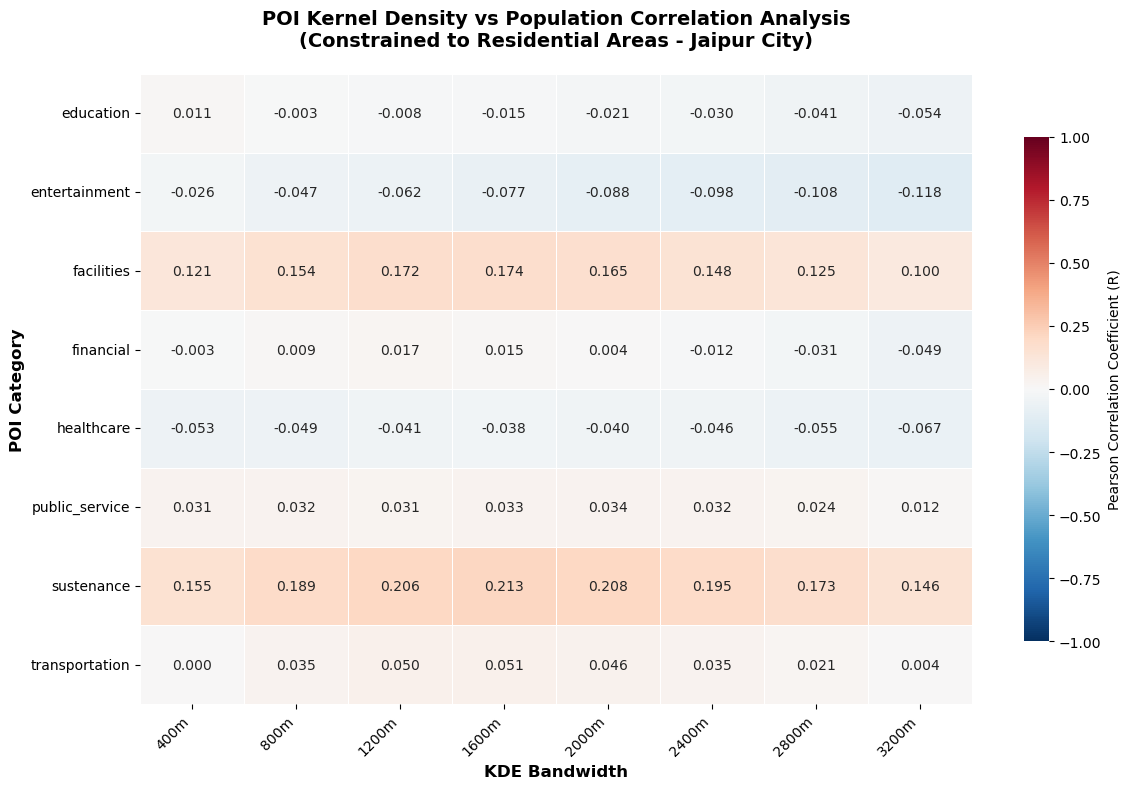

Trends plot saved to: jaipur_all_poi_correlation_trends.png


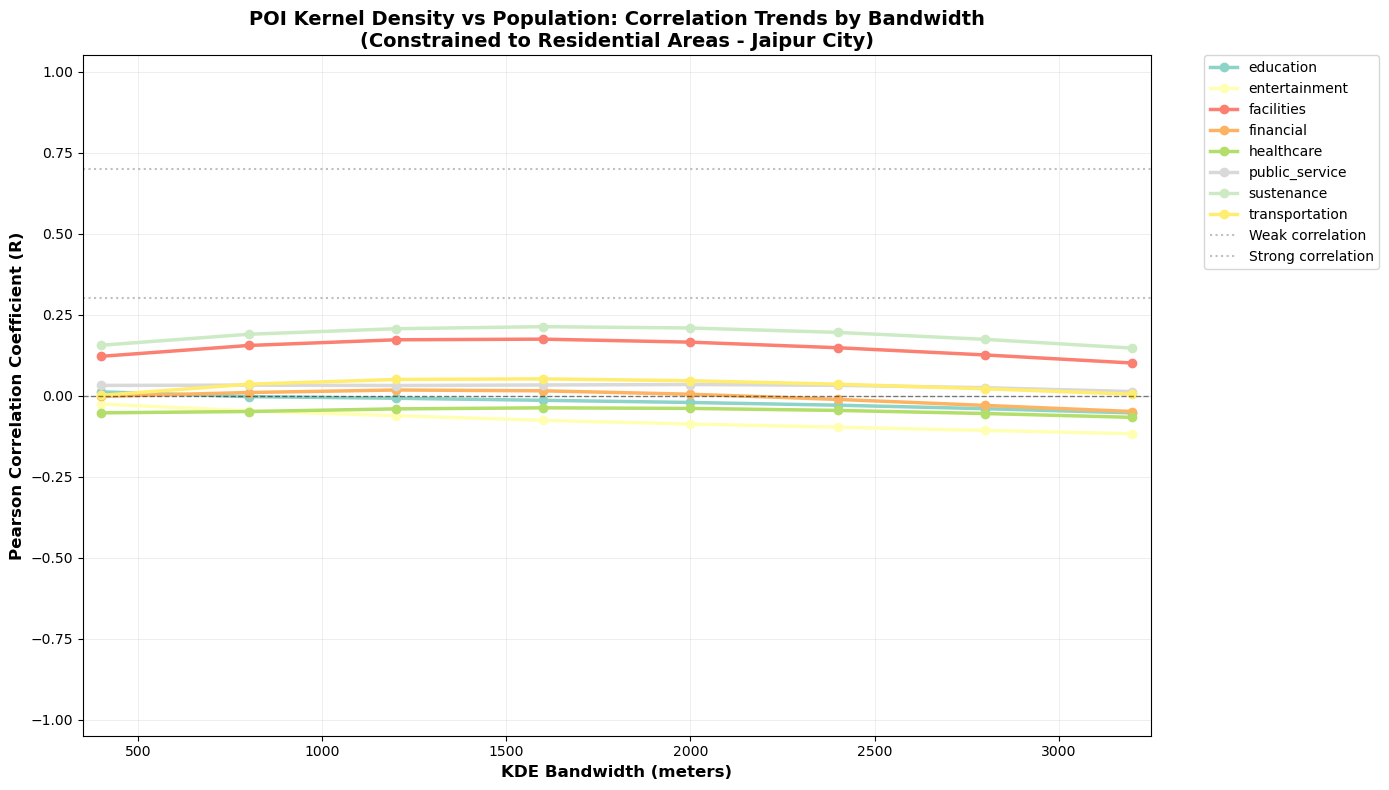

In [46]:
# visulization
analysis.create_correlation_heatmap(save_path="jaipur_all_poi_correlation_heatmap.png")
analysis.create_correlation_trends_plot(save_path="jaipur_all_poi_correlation_trends.png")



In [47]:

analysis.print_results_summary()


=== ANALYSIS RESULTS SUMMARY ===
POI Categories analyzed: 8
Bandwidths tested: 8
Analysis constrained to residential areas using GHSL mask

Highest positive correlations:
  sustenance at 1600m: R = 0.213 (p = 0.0007)
  sustenance at 2000m: R = 0.208 (p = 0.0009)
  sustenance at 1200m: R = 0.206 (p = 0.0010)

Lowest (most negative) correlations:
  entertainment at 3200m: R = -0.118 (p = 0.0619)
  entertainment at 2800m: R = -0.108 (p = 0.0888)
  entertainment at 2400m: R = -0.098 (p = 0.1223)

Overall correlation statistics:
  Mean correlation: 0.030
  Median correlation: 0.012
  Std deviation: 0.088
  Range: -0.118 to 0.213

=== OPTIMAL BANDWIDTH RECOMMENDATIONS ===

=== OPTIMAL BANDWIDTH ANALYSIS ===
education: 400m (R = 0.011)
entertainment: 400m (R = -0.026)
facilities: 1600m (R = 0.174)
financial: 1200m (R = 0.017)
healthcare: 1600m (R = -0.038)
public_service: 2000m (R = 0.034)
sustenance: 1600m (R = 0.213)
transportation: 1600m (R = 0.051)


In [52]:
import pandas as pd
import numpy as np
import os

def export_analysis_results(analysis, output_prefix="jaipur_poi_residential_analysis", output_dir="analysis/01_01 KDE_correlation_results"):
    """
    Export comprehensive analysis results to CSV files.

    Parameters:
    -----------
    analysis : POIPopulationAnalysisWithMask
        The completed analysis object
    output_prefix : str
        Prefix for output files
    output_dir : str
        Directory to save files
    """

    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"✓ Created directory: {output_dir}")

    print("=== EXPORTING ANALYSIS RESULTS ===")

    # 1. Export main correlation matrix
    correlation_file = os.path.join(output_dir, f"{output_prefix}_correlations.csv")
    analysis.correlation_results.to_csv(correlation_file)
    print(f"✓ Correlation matrix saved: {correlation_file}")

    # 2. Export p-values matrix
    pvalue_file = os.path.join(output_dir, f"{output_prefix}_pvalues.csv")
    analysis.p_value_results.to_csv(pvalue_file)
    print(f"✓ P-values matrix saved: {pvalue_file}")

    # 3. Create and export detailed p-value and bandwidth table
    create_pvalue_bandwidth_table(analysis, output_prefix, output_dir)

    # 4. Export optimal bandwidths
    optimal_bandwidths = analysis.find_optimal_bandwidths()
    if optimal_bandwidths is not None:
        optimal_file = os.path.join(output_dir, f"{output_prefix}_optimal_bandwidths.csv")
        optimal_bandwidths.to_csv(optimal_file)
        print(f"✓ Optimal bandwidths saved: {optimal_file}")

    # 5. Create comprehensive summary table
    create_comprehensive_summary(analysis, output_prefix, output_dir)

    print(f"\n✅ All results exported to: {output_dir}")

def create_pvalue_bandwidth_table(analysis, output_prefix, output_dir):
    """
    Create a detailed table showing p-values and significance levels across bandwidths.
    """
    print("\nCreating p-value and bandwidth change table...")

    # Extract bandwidths (remove 'm' and convert to int)
    bandwidths = [int(col.replace('m', '')) for col in analysis.correlation_results.columns]

    # Create detailed table
    detailed_results = []

    for poi_category in analysis.correlation_results.index:
        for i, bandwidth in enumerate(bandwidths):
            bandwidth_col = f"{bandwidth}m"

            correlation = analysis.correlation_results.loc[poi_category, bandwidth_col]
            p_value = analysis.p_value_results.loc[poi_category, bandwidth_col]

            # Determine significance level
            if pd.isna(p_value):
                significance = "No data"
                sig_stars = ""
            elif p_value < 0.001:
                significance = "Highly significant"
                sig_stars = "***"
            elif p_value < 0.01:
                significance = "Very significant"
                sig_stars = "**"
            elif p_value < 0.05:
                significance = "Significant"
                sig_stars = "*"
            else:
                significance = "Not significant"
                sig_stars = ""

            detailed_results.append({
                'POI_Category': poi_category,
                'Bandwidth_m': bandwidth,
                'Correlation_R': correlation,
                'P_Value': p_value,
                'Significance_Level': significance,
                'Stars': sig_stars,
                'Abs_Correlation': abs(correlation) if not pd.isna(correlation) else np.nan
            })

    # Convert to DataFrame
    detailed_df = pd.DataFrame(detailed_results)

    # Export detailed table
    detailed_file = os.path.join(output_dir, f"{output_prefix}_detailed_pvalue_bandwidth.csv")
    detailed_df.to_csv(detailed_file, index=False)
    print(f"✓ Detailed p-value/bandwidth table saved: {detailed_file}")

    # Create pivot table for easier reading
    pivot_correlation = detailed_df.pivot(index='POI_Category', columns='Bandwidth_m', values='Correlation_R')
    pivot_pvalue = detailed_df.pivot(index='POI_Category', columns='Bandwidth_m', values='P_Value')
    pivot_significance = detailed_df.pivot(index='POI_Category', columns='Bandwidth_m', values='Significance_Level')

    # Export pivot tables
    pivot_corr_file = os.path.join(output_dir, f"{output_prefix}_correlation_by_bandwidth.csv")
    pivot_correlation.to_csv(pivot_corr_file)

    pivot_pval_file = os.path.join(output_dir, f"{output_prefix}_pvalue_by_bandwidth.csv")
    pivot_pvalue.to_csv(pivot_pval_file)

    pivot_sig_file = os.path.join(output_dir, f"{output_prefix}_significance_by_bandwidth.csv")
    pivot_significance.to_csv(pivot_sig_file)

    print(f"✓ Pivot tables saved:")
    print(f"  - Correlations: {pivot_corr_file}")
    print(f"  - P-values: {pivot_pval_file}")
    print(f"  - Significance levels: {pivot_sig_file}")

    return detailed_df

def create_comprehensive_summary(analysis, output_prefix, output_dir):
    """
    Create a comprehensive summary with statistics for each POI category.
    """
    print("\nCreating comprehensive summary...")

    summary_data = []

    for poi_category in analysis.correlation_results.index:
        correlations = analysis.correlation_results.loc[poi_category].dropna()
        p_values = analysis.p_value_results.loc[poi_category].dropna()

        if len(correlations) > 0:
            # Find optimal bandwidth
            optimal_bandwidth = correlations.idxmax()
            optimal_correlation = correlations.max()
            optimal_pvalue = analysis.p_value_results.loc[poi_category, optimal_bandwidth]

            # Calculate statistics
            mean_correlation = correlations.mean()
            std_correlation = correlations.std()
            min_correlation = correlations.min()
            max_correlation = correlations.max()

            # Count significant results
            significant_results = sum(p_values < 0.05)
            total_results = len(p_values)

            summary_data.append({
                'POI_Category': poi_category,
                'Valid_Results': total_results,
                'Significant_Results_p<0.05': significant_results,
                'Percent_Significant': (significant_results / total_results * 100) if total_results > 0 else 0,
                'Mean_Correlation': mean_correlation,
                'Std_Correlation': std_correlation,
                'Min_Correlation': min_correlation,
                'Max_Correlation': max_correlation,
                'Optimal_Bandwidth': optimal_bandwidth,
                'Optimal_Correlation': optimal_correlation,
                'Optimal_P_Value': optimal_pvalue,
                'Range_Correlation': max_correlation - min_correlation
            })
        else:
            summary_data.append({
                'POI_Category': poi_category,
                'Valid_Results': 0,
                'Significant_Results_p<0.05': 0,
                'Percent_Significant': 0,
                'Mean_Correlation': np.nan,
                'Std_Correlation': np.nan,
                'Min_Correlation': np.nan,
                'Max_Correlation': np.nan,
                'Optimal_Bandwidth': 'No data',
                'Optimal_Correlation': np.nan,
                'Optimal_P_Value': np.nan,
                'Range_Correlation': np.nan
            })

    summary_df = pd.DataFrame(summary_data)

    # Sort by optimal correlation (descending) 
    try:
      
        summary_df = summary_df.sort_values('Optimal_Correlation', ascending=False, na_position='last')
    except TypeError:
        try:
            
            summary_df = summary_df.sort_values('Optimal_Correlation', ascending=False, na_last=True)
        except TypeError:
            
            summary_df_valid = summary_df[~summary_df['Optimal_Correlation'].isna()]
            summary_df_nan = summary_df[summary_df['Optimal_Correlation'].isna()]
            summary_df_valid = summary_df_valid.sort_values('Optimal_Correlation', ascending=False)
            summary_df = pd.concat([summary_df_valid, summary_df_nan], ignore_index=True)

    # Export summary
    summary_file = os.path.join(output_dir, f"{output_prefix}_comprehensive_summary.csv")
    summary_df.to_csv(summary_file, index=False)
    print(f"✓ Comprehensive summary saved: {summary_file}")

    return summary_df

def print_quick_summary(analysis):
    """
    Print a quick summary to console.
    """
    print("\n" + "="*60)
    print("QUICK ANALYSIS SUMMARY")
    print("="*60)

    # Overall statistics
    all_correlations = analysis.correlation_results.values.flatten()
    valid_correlations = all_correlations[~np.isnan(all_correlations)]

    print(f"Total POI categories: {len(analysis.correlation_results.index)}")
    print(f"Total bandwidths tested: {len(analysis.correlation_results.columns)}")
    print(f"Valid correlation results: {len(valid_correlations)}")

    if len(valid_correlations) > 0:
        print(f"Mean correlation: {np.mean(valid_correlations):.3f}")
        print(f"Median correlation: {np.median(valid_correlations):.3f}")
        print(f"Range: {np.min(valid_correlations):.3f} to {np.max(valid_correlations):.3f}")

    # Top 3 highest correlations
    print(f"\nTOP 3 HIGHEST CORRELATIONS:")
    top_correlations = analysis.correlation_results.stack().nlargest(3)
    for i, ((poi, bandwidth), corr) in enumerate(top_correlations.items(), 1):
        p_val = analysis.p_value_results.loc[poi, bandwidth]
        significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
        print(f"{i}. {poi} at {bandwidth}: R = {corr:.3f}, p = {p_val:.4f} {significance}")

    print("="*60)

# Usage function
def run_complete_export(analysis, output_prefix="jaipur_poi_residential_analysis", output_dir="analysis/01_01 KDE_correlation_results"):
    """
    Run complete export process.

    Parameters:
    -----------
    analysis : POIPopulationAnalysisWithMask
        The completed analysis object with results
    output_prefix : str
        Prefix for all output files
    output_dir : str
        Directory to save all files
    """

    if not hasattr(analysis, 'correlation_results'):
        print("❌ Error: No analysis results found. Please run analysis.run_complete_analysis() first.")
        return

    # Export all results
    export_analysis_results(analysis, output_prefix, output_dir)

    # Print quick summary
    print_quick_summary(analysis)

    # List all generated files
    import glob
    files = glob.glob(os.path.join(output_dir, f"{output_prefix}*.csv"))
    print(f"\n📁 Generated {len(files)} CSV files in {output_dir}:")
    for file in sorted(files):
        print(f"  - {os.path.basename(file)}")

# Example usage:
if __name__ == "__main__":
    print("Export functions ready!")
    print("After running your analysis, use:")
    print('run_complete_export(analysis, output_dir="analysis/01_01 KDE_correlation_results")')

Export functions ready!
After running your analysis, use:
run_complete_export(analysis, output_dir="analysis/01_01 KDE_correlation_results")


In [53]:
run_complete_export(
    analysis,
    output_prefix="jaipur_poi_residential_analysis",
    output_dir="analysis/01_01 KDE_correlation_results"
)

=== EXPORTING ANALYSIS RESULTS ===
✓ Correlation matrix saved: analysis/01_01 KDE_correlation_results\jaipur_poi_residential_analysis_correlations.csv
✓ P-values matrix saved: analysis/01_01 KDE_correlation_results\jaipur_poi_residential_analysis_pvalues.csv

Creating p-value and bandwidth change table...
✓ Detailed p-value/bandwidth table saved: analysis/01_01 KDE_correlation_results\jaipur_poi_residential_analysis_detailed_pvalue_bandwidth.csv
✓ Pivot tables saved:
  - Correlations: analysis/01_01 KDE_correlation_results\jaipur_poi_residential_analysis_correlation_by_bandwidth.csv
  - P-values: analysis/01_01 KDE_correlation_results\jaipur_poi_residential_analysis_pvalue_by_bandwidth.csv
  - Significance levels: analysis/01_01 KDE_correlation_results\jaipur_poi_residential_analysis_significance_by_bandwidth.csv

=== OPTIMAL BANDWIDTH ANALYSIS ===
education: 400m (R = 0.011)
entertainment: 400m (R = -0.026)
facilities: 1600m (R = 0.174)
financial: 1200m (R = 0.017)
healthcare: 1600m (

# 2 Summary of Correlation Analysis Between POI Kernel Densities and Ward-Level Population

After performing kernel density estimation (KDE) for each POI category and aggregating the results over residential building footprints within each ward, we computed the Pearson correlation matrix between KDE values and ward-level population across various bandwidths. The analysis reveals that the overall correlation reaches its peak when the bandwidth is set to 1600 meters.

At this optimal bandwidth, sustenance (e.g., restaurants) and facilities categories exhibit the highest and most statistically significant positive correlations with population (based on their p-values). This suggests that areas with more concentrated sustenance and facility-related services tend to have higher population densities at the ward level.

Although the healthcare category ranks just behind sustenance and facilities in terms of correlation strength—and has the highest number of POI records among all categories—its p-value at the 1600m bandwidth is not statistically significant. Therefore, despite its high correlation, we decided not to retain the healthcare KDE layer in subsequent modeling.

The lack of statistical significance for healthcare may be related to the spatial planning and distribution of medical infrastructure in Jaipur, which might not align closely with actual residential population patterns

# 3 Export Selected POI KDE

In [54]:
import numpy as np
import rasterio
from rasterio.transform import from_bounds
import os

def export_kde_rasters_to_tiff(analysis, poi_categories=['sustenance', 'facilities'],
                              bandwidth=1600, output_dir="analysis/01_01 KDE_correlation_results",
                              pixel_size=100):
    """
    Export KDE rasters for specific POI categories to TIFF files.

    Parameters:
    -----------
    analysis : POIPopulationAnalysisWithMask
        The analysis object with all methods
    poi_categories : list
        List of POI categories to export (default: ['sustenance', 'facilities'])
    bandwidth : int
        Bandwidth in meters (default: 1600)
    output_dir : str
        Directory to save TIFF files
    pixel_size : int
        Pixel resolution in meters (default: 100)
    """

    print("=== EXPORTING KDE RASTERS TO TIFF ===")
    print(f"POI Categories: {poi_categories}")
    print(f"Bandwidth: {bandwidth}m")
    print(f"Resolution: {pixel_size}m")
    print(f"CRS: EPSG:32643")
    print(f"Output directory: {output_dir}")

    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"✓ Created directory: {output_dir}")

    # Ensure analysis grid is created with correct resolution
    analysis.create_analysis_grid(pixel_size=pixel_size)

    # Create residential mask for analysis
    print("\nCreating residential mask...")
    residential_mask = analysis.create_residential_mask_for_analysis()

    # Process each POI category
    for poi_category in poi_categories:
        print(f"\n--- Processing POI Category: '{poi_category}' ---")

        try:
            # Step 1: Perform kernel density estimation
            print(f"  Performing KDE with {bandwidth}m bandwidth...")
            kde_raster = analysis.perform_kde_raster(poi_category, bandwidth)

            # Step 2: Clip to city boundary
            print(f"  Clipping to city boundary...")
            clipped_raster = analysis.clip_raster_to_city(kde_raster)

            # Step 3: Apply residential mask (non-residential areas = 0)
            print(f"  Applying residential mask...")
            masked_kde_raster = analysis.apply_residential_mask(clipped_raster, residential_mask)

            # Step 4: Export to TIFF
            output_filename = f"kde_{poi_category}_{bandwidth}m_residential_masked.tif"
            output_path = os.path.join(output_dir, output_filename)

            print(f"  Exporting to TIFF: {output_filename}")
            export_raster_to_tiff(
                raster_data=masked_kde_raster,
                output_path=output_path,
                transform=analysis.analysis_transform,
                crs='EPSG:32643',
                nodata=0
            )

            # Print statistics
            total_pixels = masked_kde_raster.size
            nonzero_pixels = np.sum(masked_kde_raster > 0)
            min_val = np.min(masked_kde_raster[masked_kde_raster > 0]) if nonzero_pixels > 0 else 0
            max_val = np.max(masked_kde_raster)
            mean_val = np.mean(masked_kde_raster[masked_kde_raster > 0]) if nonzero_pixels > 0 else 0

            print(f"  Statistics:")
            print(f"    Total pixels: {total_pixels:,}")
            print(f"    Non-zero pixels: {nonzero_pixels:,} ({nonzero_pixels/total_pixels*100:.1f}%)")
            print(f"    Value range: {min_val:.6f} to {max_val:.6f}")
            print(f"    Mean (non-zero): {mean_val:.6f}")
            print(f"  ✓ Successfully exported: {output_path}")

        except Exception as e:
            print(f"  ❌ Error processing {poi_category}: {str(e)}")
            continue

    print(f"\n✅ KDE TIFF export complete!")

def export_raster_to_tiff(raster_data, output_path, transform, crs='EPSG:32643',
                         nodata=0, dtype=None):
    """
    Export numpy array as GeoTIFF file.

    Parameters:
    -----------
    raster_data : numpy.ndarray
        2D array of raster values
    output_path : str
        Path for output TIFF file
    transform : rasterio.Affine
        Raster transform for georeferencing
    crs : str
        Coordinate reference system (default: 'EPSG:32643')
    nodata : float
        NoData value (default: 0)
    dtype : str
        Data type for output (default: auto-detect)
    """

    if dtype is None:
        # Use float32 for KDE values to preserve precision while saving space
        dtype = 'float32'

    # Get raster dimensions
    height, width = raster_data.shape

    # Create and write TIFF file
    with rasterio.open(
        output_path,
        'w',
        driver='GTiff',
        height=height,
        width=width,
        count=1,
        dtype=dtype,
        crs=crs,
        transform=transform,
        nodata=nodata,
        compress='lzw',  # Use LZW compression to reduce file size
        tiled=True,      # Enable tiling for better performance
        blockxsize=256,  # Tile size
        blockysize=256
    ) as dst:
        # Convert data type if necessary
        if dtype == 'float32':
            raster_data = raster_data.astype(np.float32)

        # Write the raster data
        dst.write(raster_data, 1)

        # Add metadata
        dst.update_tags(
            AREA_OR_POINT='Area',
            DESCRIPTION=f'POI Kernel Density with Residential Mask',
            UNITS='Density per square meter'
        )

def export_all_significant_kde_rasters(analysis, output_dir="analysis/01_01 KDE_correlation_results",
                                     pixel_size=100):
    """
    Export KDE rasters for all significant POI categories at their optimal bandwidths.

    Parameters:
    -----------
    analysis : POIPopulationAnalysisWithMask
        The analysis object with correlation results
    output_dir : str
        Directory to save TIFF files
    pixel_size : int
        Pixel resolution in meters
    """

    print("=== EXPORTING ALL SIGNIFICANT KDE RASTERS ===")

    if not hasattr(analysis, 'correlation_results'):
        print("❌ Error: No analysis results found. Run analysis first.")
        return

    # Find optimal bandwidths for each POI category
    optimal_bandwidths = analysis.find_optimal_bandwidths()

    # Filter for significant correlations (you can adjust the threshold)
    significant_pois = []
    correlation_threshold = 0.1  # Minimum correlation to consider

    for poi_category in analysis.correlation_results.index:
        correlations = analysis.correlation_results.loc[poi_category].dropna()
        if len(correlations) > 0:
            max_correlation = correlations.max()
            if abs(max_correlation) >= correlation_threshold:
                optimal_bandwidth = correlations.idxmax()
                # Extract bandwidth number
                bandwidth_num = int(optimal_bandwidth.replace('m', ''))
                significant_pois.append((poi_category, bandwidth_num, max_correlation))

    # Sort by correlation strength
    significant_pois.sort(key=lambda x: abs(x[2]), reverse=True)

    print(f"Found {len(significant_pois)} POI categories with |correlation| >= {correlation_threshold}:")
    for poi, bandwidth, corr in significant_pois:
        print(f"  {poi}: {bandwidth}m (R = {corr:.3f})")

    # Export each significant POI category
    analysis.create_analysis_grid(pixel_size=pixel_size)
    residential_mask = analysis.create_residential_mask_for_analysis()

    for poi_category, bandwidth, correlation in significant_pois:
        print(f"\n--- Exporting {poi_category} at {bandwidth}m (R = {correlation:.3f}) ---")

        try:
            # Perform KDE and apply masks
            kde_raster = analysis.perform_kde_raster(poi_category, bandwidth)
            clipped_raster = analysis.clip_raster_to_city(kde_raster)
            masked_kde_raster = analysis.apply_residential_mask(clipped_raster, residential_mask)

            # Export to TIFF
            output_filename = f"kde_{poi_category}_{bandwidth}m_R{correlation:.3f}_residential_masked.tif"
            output_path = os.path.join(output_dir, output_filename)

            export_raster_to_tiff(
                raster_data=masked_kde_raster,
                output_path=output_path,
                transform=analysis.analysis_transform,
                crs='EPSG:32643',
                nodata=0
            )

            print(f"  ✓ Exported: {output_filename}")

        except Exception as e:
            print(f"  ❌ Error: {str(e)}")
            continue

    print(f"\n✅ All significant KDE rasters exported to: {output_dir}")

# Quick function for the specific request
def export_sustenance_facilities_1600m(analysis, output_dir="analysis/01_01 KDE_correlation_results"):
    """
    Quick function to export sustenance and facilities KDE at 1600m bandwidth.
    """
    export_kde_rasters_to_tiff(
        analysis=analysis,
        poi_categories=['sustenance', 'facilities'],
        bandwidth=1600,
        output_dir=output_dir,
        pixel_size=100
    )

# Example usage
if __name__ == "__main__":
    print("KDE TIFF Export Functions Ready!")
    print("\nUsage examples:")
    print("1. Export specific POIs at 1600m:")
    print("   export_sustenance_facilities_1600m(analysis)")
    print("\n2. Export custom POIs and bandwidth:")
    print("   export_kde_rasters_to_tiff(analysis, ['sustenance'], bandwidth=1200)")
    print("\n3. Export all significant POI categories:")
    print("   export_all_significant_kde_rasters(analysis)")

KDE TIFF Export Functions Ready!

Usage examples:
1. Export specific POIs at 1600m:
   export_sustenance_facilities_1600m(analysis)

2. Export custom POIs and bandwidth:
   export_kde_rasters_to_tiff(analysis, ['sustenance'], bandwidth=1200)

3. Export all significant POI categories:
   export_all_significant_kde_rasters(analysis)


In [55]:
# export
export_sustenance_facilities_1600m(analysis, "data/cleaned")

=== EXPORTING KDE RASTERS TO TIFF ===
POI Categories: ['sustenance', 'facilities']
Bandwidth: 1600m
Resolution: 100m
CRS: EPSG:32643
Output directory: data/cleaned
Created analysis grid: 243x301 pixels (100m resolution)
Grid covers 24.2km x 30.1km area

Creating residential mask...
Creating residential mask for analysis grid...
Analysis grid residential pixels: 15463 (21.1%)
Residential mask will preserve KDE values where GHSL > 0

--- Processing POI Category: 'sustenance' ---
  Performing KDE with 1600m bandwidth...
  Processing 362 POIs for category 'sustenance'
    Using 362 coordinate pairs for KDE
  Clipping to city boundary...
  Applying residential mask...
    Residential masking: retained 56.2% of KDE values
  Exporting to TIFF: kde_sustenance_1600m_residential_masked.tif
  Statistics:
    Total pixels: 73,143
    Non-zero pixels: 15,362 (21.0%)
    Value range: 0.000000 to 0.000000
    Mean (non-zero): 0.000000
  ✓ Successfully exported: data/cleaned\kde_sustenance_1600m_resid

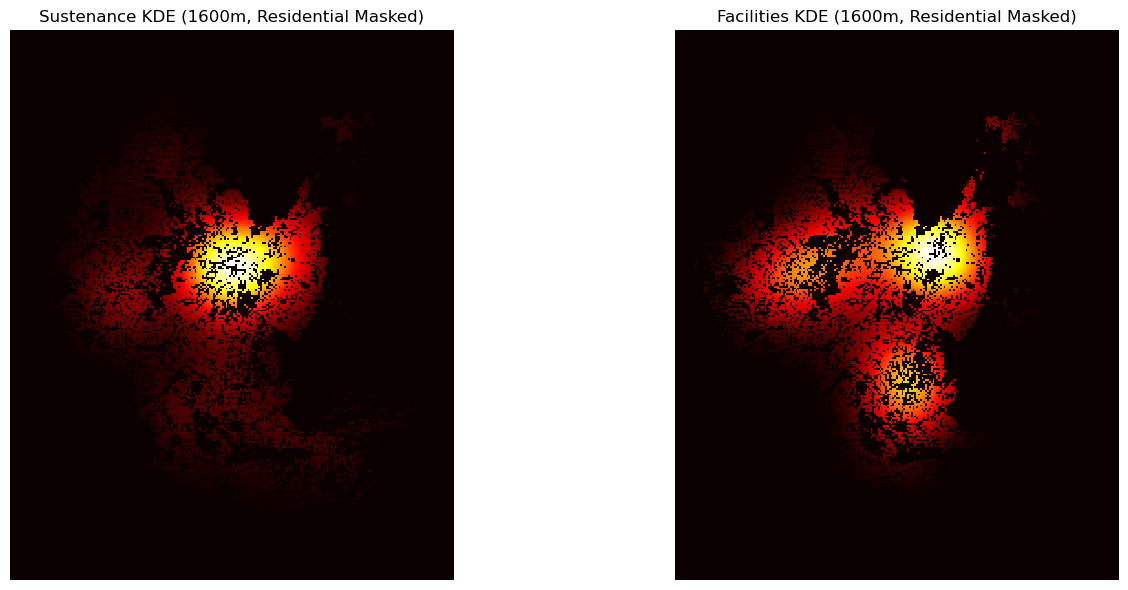

In [56]:
# print
import rasterio
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
for i, poi in enumerate(['sustenance', 'facilities']):
    with rasterio.open(f"data/cleaned/kde_{poi}_1600m_residential_masked.tif") as src:
        data = src.read(1)
        axes[i].imshow(data, cmap='hot', interpolation='nearest')
        axes[i].set_title(f'{poi.title()} KDE (1600m, Residential Masked)')
        axes[i].axis('off')
plt.tight_layout(); plt.show()